In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Embedding, Reshape, Input, concatenate, Flatten
from tensorflow.keras.models import Model

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
games = pd.read_csv(r'/content/drive/MyDrive/games.csv')
games.columns.values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


array(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home',
       'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home',
       'REB_home', 'TEAM_ID_away', 'PTS_away', 'FG_PCT_away',
       'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'HOME_TEAM_WINS'], dtype=object)

In [ ]:

#zmiana ID druzyn do prostych wartosci 0 - 29
team_id = games['HOME_TEAM_ID'].unique()
games = games.replace(team_id, np.arange(0,30,1))
games

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,0,20,2022,0,126.0,0.484,0.926,...,25.0,46.0,20,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1,27,2022,1,120.0,0.488,0.952,...,16.0,40.0,27,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,2,21,2022,2,114.0,0.482,0.786,...,22.0,37.0,21,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,3,13,2022,3,113.0,0.441,0.909,...,27.0,49.0,13,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,4,23,2022,4,108.0,0.429,1.000,...,22.0,47.0,23,110.0,0.500,0.773,0.292,20.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,Final,4,0,2014,4,93.0,0.419,0.821,...,24.0,50.0,0,87.0,0.366,0.643,0.375,17.0,43.0,1
26647,2014-10-06,11400004,Final,23,27,2014,23,81.0,0.338,0.719,...,18.0,40.0,27,85.0,0.411,0.636,0.267,17.0,47.0,0
26648,2014-10-06,11400005,Final,19,16,2014,19,98.0,0.448,0.682,...,29.0,45.0,16,95.0,0.387,0.659,0.500,19.0,43.0,1
26649,2014-10-05,11400002,Final,18,11,2014,18,99.0,0.440,0.771,...,21.0,30.0,11,94.0,0.469,0.725,0.385,18.0,45.0,1


In [ ]:
def divide_seasons(season_1, season_2, feature ,pd_games = games):
    result_1 = pd_games[pd_games['SEASON'] == season_1]
    result_2 = pd_games[pd_games['SEASON'] == season_2]
    result = pd.concat([result_1, result_2])
    result = result.loc[: , ~result.columns.isin(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away', 'SEASON'])]
    X_result_id = result.loc[: , ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].to_numpy()
    y_result_win = result['HOME_TEAM_WINS'].to_numpy()
    y_result_feat = result[feature].to_numpy()
    return X_result_id, y_result_feat, y_result_win


In [ ]:
#generator do tworzenia wykresow

features = ['PTS_home',
       'AST_home', 'AST_away', 'REB_away',
       'REB_home','PTS_away', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'FG_PCT_away',
       'FT_PCT_away','FG3_PCT_away'
]



#feature = 'AST_away'    #domyslna wartosc

In [ ]:

def generator(lista):
  for number in lista:
    yield number

#gen = generator(features)  #/// odkomentowac do tworzenia 1 wykresu, pozniej zakomentowac


In [ ]:

feature = next(gen)
print(feature)


FG3_PCT_away


In [ ]:
feature_split = feature.split("_")

if 'PCT' in feature_split:
  activ_func = 'sigmoid'
else:
  activ_func = 'relu'

activ_func

'sigmoid'

In [ ]:
#zbior treningowy 2017/18 + 2018/19
X_train_id, y_train_feat, y_train_win = divide_seasons(2017, 2018, feature)

#zbior walidacyjny 2019/20   2020/21
X_valid_id, y_valid_feat, y_valid_win = divide_seasons(2019, 2020, feature)       #mniejsza ilosc meczy ze wzgledu na COVID

#zbior testowy - 2021/22 2022/23
X_test_id, y_test_feat, y_test_win  = divide_seasons(2021, 2022, feature)       #roznica w ilosci wynika z niedokonczonego sezonu 2022 (do konca grudnia)

In [ ]:
#model_feat - feature
input_embedding_feat = Input(shape = (2,))
embedding_feat = Embedding(input_dim=30, output_dim=5, input_length=2)(input_embedding_feat)
embedding_feat = Dense(100)(embedding_feat)
embedding_feat = Flatten()(embedding_feat)
output_feat = Dense(1, activation = activ_func)(embedding_feat)

model_feat = Model(input_embedding_feat, output_feat)
model_feat.compile(optimizer = 'adam', loss = 'mse')
model_feat.summary()
r_feat = model_feat.fit(X_train_id, y_train_feat, epochs = 100, validation_data = (X_valid_id, y_valid_feat))

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 2)]               0         
                                                                 
 embedding_48 (Embedding)    (None, 2, 5)              150       
                                                                 
 dense_120 (Dense)           (None, 2, 100)            600       
                                                                 
 flatten_48 (Flatten)        (None, 200)               0         
                                                                 
 dense_121 (Dense)           (None, 1)                 201       
                                                                 
Total params: 951 (3.71 KB)
Trainable params: 951 (3.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
87/87 [=========

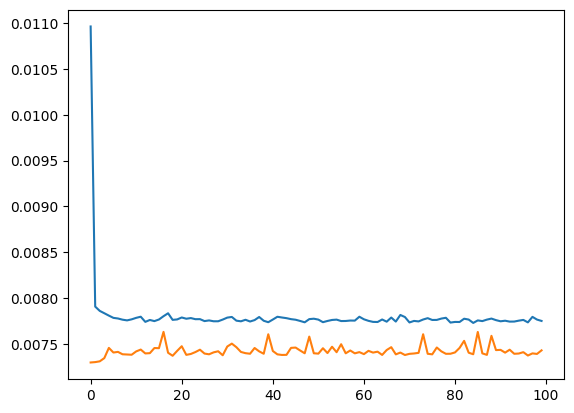

In [ ]:
plt.plot(r_feat.history['loss'])
plt.plot(r_feat.history['val_loss'])

In [ ]:
#freeze wag model_feat
for layer in model_feat.layers[:5]:
    layer.trainable=False
print(output_feat.shape)

#model - win
input_embedding_win = Input(shape = (2,))
embedding_win = Embedding(input_dim=30, output_dim=5, input_length=2)(input_embedding_win)
embedding_win = Flatten()(embedding_win)
print(embedding_win.shape)

merged = concatenate([output_feat, embedding_win])

merged = Dense(64, activation = 'relu')(merged)
merged = Dense(64, activation = 'relu')(merged)
output = Dense(1, activation = 'sigmoid')(merged)

model_win = Model(inputs = [input_embedding_win, input_embedding_feat], outputs = output)
model_win.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_win.summary()

(None, 1)
(None, 10)
Model: "model_49"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 2)]                  0         []                            
                                                                                                  
 embedding_48 (Embedding)    (None, 2, 5)                 150       ['input_49[0][0]']            
                                                                                                  
 dense_120 (Dense)           (None, 2, 100)               600       ['embedding_48[0][0]']        
                                                                                                  
 input_50 (InputLayer)       [(None, 2)]                  0         []                            
                                                                      

In [ ]:
r = model_win.fit([X_train_id, X_train_id], y_train_win, epochs = 100, validation_data = ([X_valid_id,X_valid_id] , y_valid_win))

Epoch 1/100
87/87 [==============================] - 2s 7ms/step - loss: 0.6797 - accuracy: 0.5826 - val_loss: 0.6977 - val_accuracy: 0.5410
Epoch 2/100
87/87 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6272 - val_loss: 0.7265 - val_accuracy: 0.5378
Epoch 3/100
87/87 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6670 - val_loss: 0.7337 - val_accuracy: 0.5369
Epoch 4/100
87/87 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6674 - val_loss: 0.7334 - val_accuracy: 0.5337
Epoch 5/100
87/87 [==============================] - 0s 4ms/step - loss: 0.6110 - accuracy: 0.6746 - val_loss: 0.7508 - val_accuracy: 0.5386
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 0.6099 - accuracy: 0.6670 - val_loss: 0.7432 - val_accuracy: 0.5357
Epoch 7/100
87/87 [==============================] - 0s 4ms/step - loss: 0.6076 - accuracy: 0.6707 - val_loss: 0.7523 - val_accuracy: 0.5317
Epoch 8/100
8

In [ ]:
layers = 3

for layer in model_feat.layers[-layers:]:      #wlaczamy 3 ostatnie warstwy czyli Dense(100), Flatten i Dense(1)
  layer.trainable = True

model_win.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
r_2 = model_win.fit([X_train_id, X_train_id], y_train_win, epochs = 100, validation_data = ([X_valid_id,X_valid_id] , y_valid_win))

Epoch 1/100
87/87 [==============================] - 2s 7ms/step - loss: 0.5574 - accuracy: 0.7014 - val_loss: 0.8216 - val_accuracy: 0.5048
Epoch 2/100
87/87 [==============================] - 0s 4ms/step - loss: 0.5530 - accuracy: 0.7134 - val_loss: 0.8468 - val_accuracy: 0.5145
Epoch 3/100
87/87 [==============================] - 0s 4ms/step - loss: 0.5552 - accuracy: 0.7036 - val_loss: 0.8495 - val_accuracy: 0.5193
Epoch 4/100
87/87 [==============================] - 1s 6ms/step - loss: 0.5542 - accuracy: 0.7036 - val_loss: 0.8354 - val_accuracy: 0.5092
Epoch 5/100
87/87 [==============================] - 1s 6ms/step - loss: 0.5525 - accuracy: 0.7069 - val_loss: 0.8370 - val_accuracy: 0.5149
Epoch 6/100
87/87 [==============================] - 1s 8ms/step - loss: 0.5511 - accuracy: 0.7156 - val_loss: 0.8478 - val_accuracy: 0.5080
Epoch 7/100
87/87 [==============================] - 1s 6ms/step - loss: 0.5543 - accuracy: 0.7033 - val_loss: 0.8331 - val_accuracy: 0.5112
Epoch 8/100
8

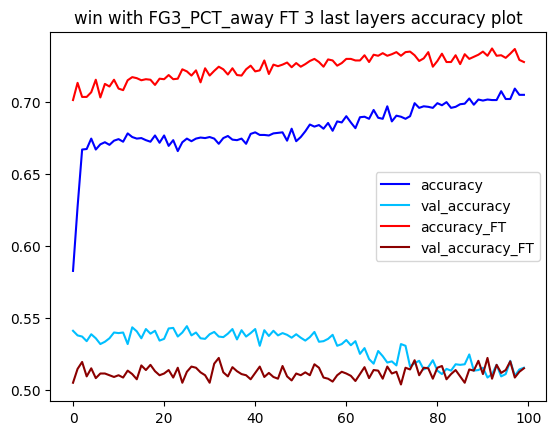

In [ ]:
plt.plot(r.history['accuracy'], label = 'accuracy', color = 'blue')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy', color = 'deepskyblue')
plt.plot(r_2.history['accuracy'], label = 'accuracy_FT', color = 'red')
plt.plot(r_2.history['val_accuracy'], label = 'val_accuracy_FT', color = 'darkred')
plt.title('win with ' + feature + ' FT '+ str(layers) +' last layers accuracy plot')
plt.legend()

filename_acc = '/content/win_accuracy_plot-' + feature + '.jpg'
plt.savefig(filename_acc, format = 'jpg')


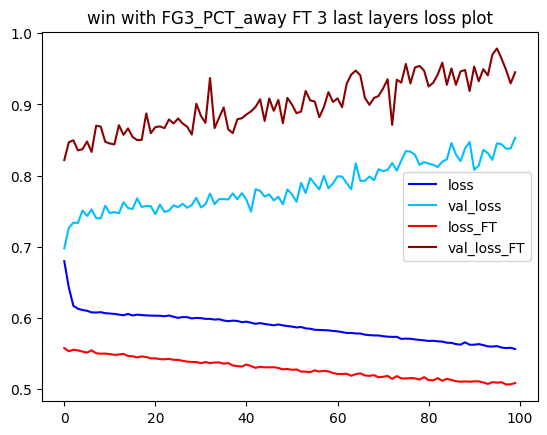

In [ ]:

plt.plot(r.history['loss'], label = 'loss', color = 'blue')
plt.plot(r.history['val_loss'], label = 'val_loss', color = 'deepskyblue')
plt.plot(r_2.history['loss'], label = 'loss_FT', color = 'red')
plt.plot(r_2.history['val_loss'], label = 'val_loss_FT', color = 'darkred')
plt.title('win with ' + feature + ' FT '+ str(layers) +' last layers loss plot')
plt.legend()

filename_loss = '/content/win_loss_plot-' + feature + '.jpg'
plt.savefig(filename_loss, format = 'jpg')

In [ ]:
from google.colab import files

files.download(filename_acc)
files.download(filename_loss)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>